In [1]:
#Importing packages
import matplotlib as mpl
import matplotlib.dates as md
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import sklearn as sk
import pandas as pd
import statsmodels.api as sts
from statsmodels.api import add_constant

#Importing data here
whole_data = pd.read_csv('train_v2.csv') 

#Separating data into test & train; train will be called "master_data", test will be called "test_data"
master_data = whole_data[:3779920]
test_data = whole_data[3779921:-1]

### Descriptive Statistics

In [2]:
#Below are the essential descriptive statistics for each of my numeric variables. 
pd.set_option('display.max_columns', None)
#The above line is added in to ensure that the information for all columns gets printed.
print(master_data.describe(), master_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779920 entries, 0 to 3779919
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

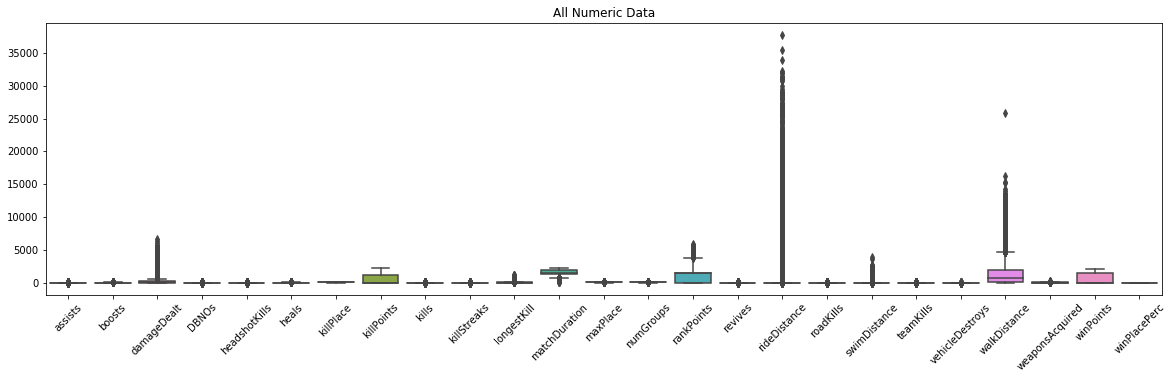

In [3]:
#While the above could certainly serve, a visualization of my data would help. As well, from here on
#I'll be working with the numerical data and dropping player, group, and match IDs. Match type will come in later. 
numeric = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 
             'numGroups', 'rankPoints', 'revives', 'rideDistance','roadKills', 'swimDistance', 'teamKills', 
             'vehicleDestroys', 'walkDistance', 'weaponsAcquired','winPoints', 'winPlacePerc']
numeric_data = master_data[numeric]
def box_output(i) :
    mpl.rcParams['figure.figsize'] = (20,5)
    sb.boxplot(data=i)
    plt.xticks(rotation=45)
box_output(numeric_data)
plt.title("All Numeric Data")
plt.show()

In [5]:
#The following is the respective number of points above and below the win percentage mean. I've calculated this for my 
#boxplots below so that I can begin to deduce which variables might be influential to a potential regression model. 
above_avg = numeric_data[numeric_data.winPlacePerc >= np.mean(numeric_data.winPlacePerc)]
below_avg = numeric_data[numeric_data.winPlacePerc < np.mean(numeric_data.winPlacePerc)]
print('There are ' + str(len(above_avg)) + ' players who have a higher than average win place percentage')
print('There are ' + str(len(below_avg)) + ' players who have a lower than average win place percentage')

There are 1838707 players who have a higher than average win place percentage
There are 1941212 players who have a lower than average win place percentage


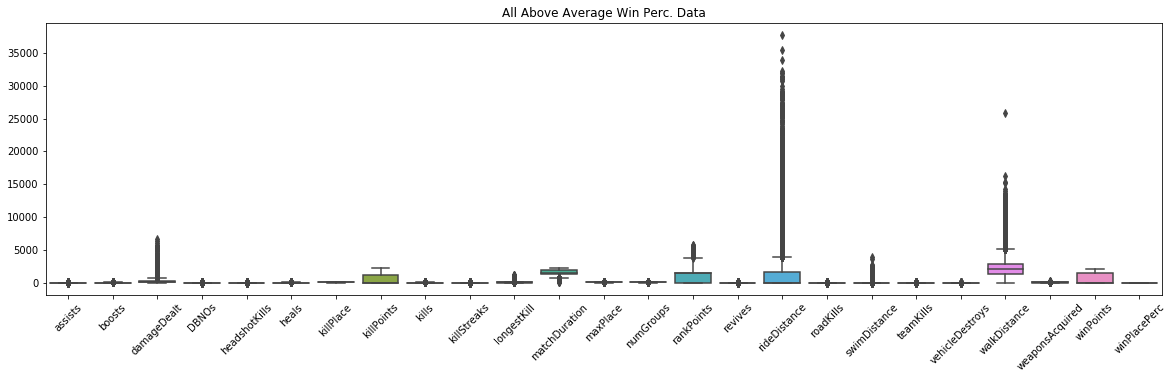

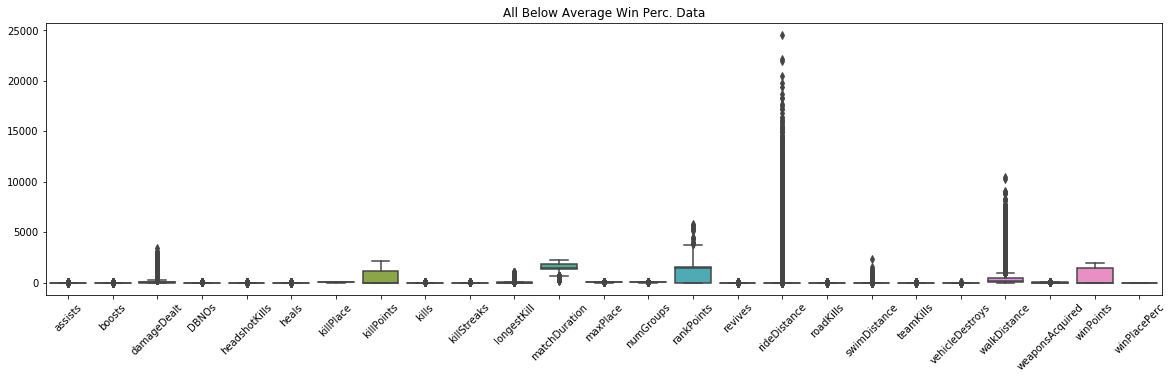

In [6]:
#The following are the boxplots with above average performance and below average performance
box_output(above_avg)
plt.title("All Above Average Win Perc. Data")
plt.show()
box_output(below_avg)
plt.title("All Below Average Win Perc. Data")
plt.show()

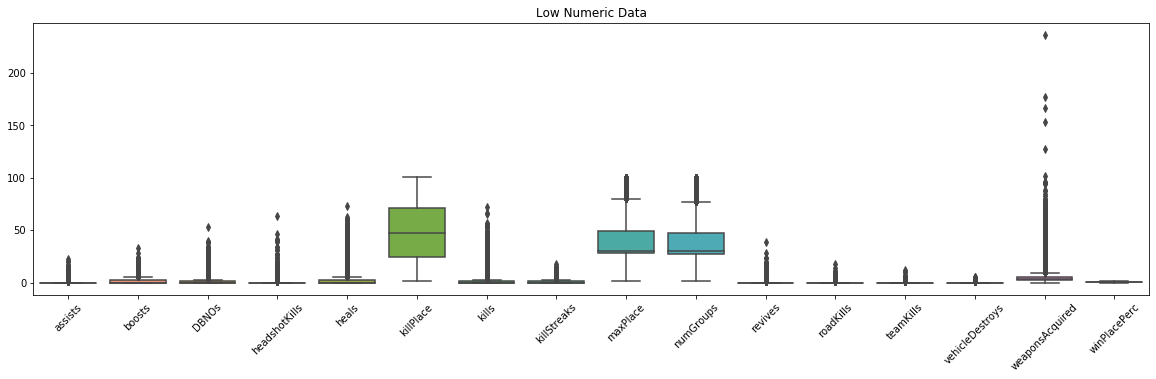

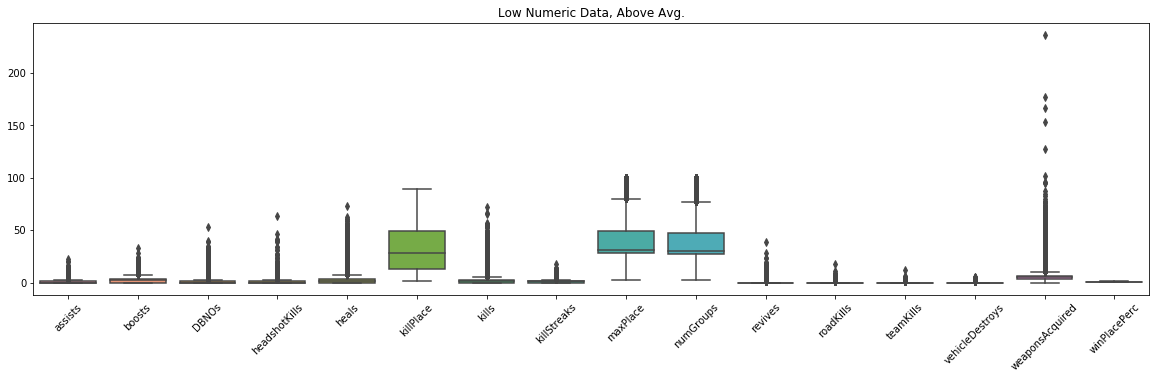

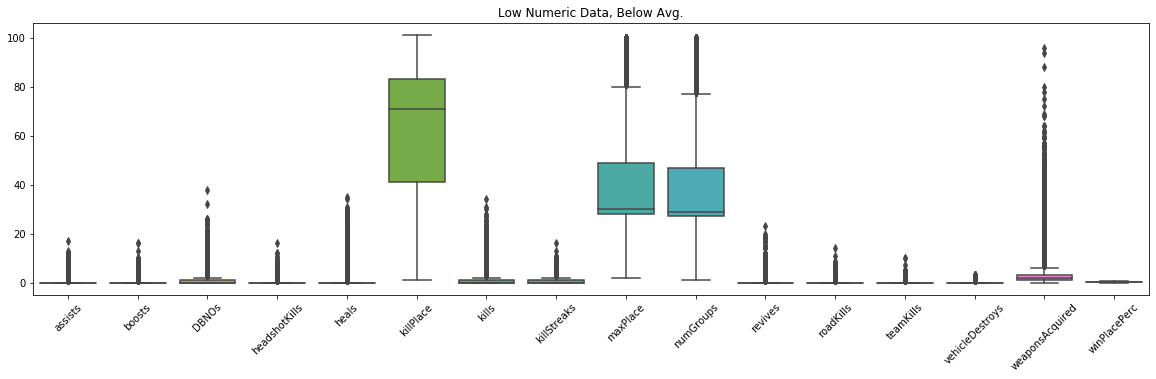

In [7]:
#Since some of the variables above can vary quite drastically, I figured it'd help to zoom in on my smaller variables.
#I've made three boxplots - one for all points, another for above avg. win perc, and another for below avg. win perc.
low = ['assists', 'boosts', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
       'kills', 'killStreaks', 'maxPlace', 'numGroups', 'revives', 'roadKills', 'teamKills', 
             'vehicleDestroys', 'weaponsAcquired', 'winPlacePerc']
low_numeric = numeric_data[low]
above_low = above_avg[low]
below_low = below_avg[low]
box_output(low_numeric)
plt.title("Low Numeric Data")
plt.show()
box_output(above_low)
plt.title("Low Numeric Data, Above Avg.")
plt.show()
box_output(below_low)
plt.title("Low Numeric Data, Below Avg.")
plt.show()

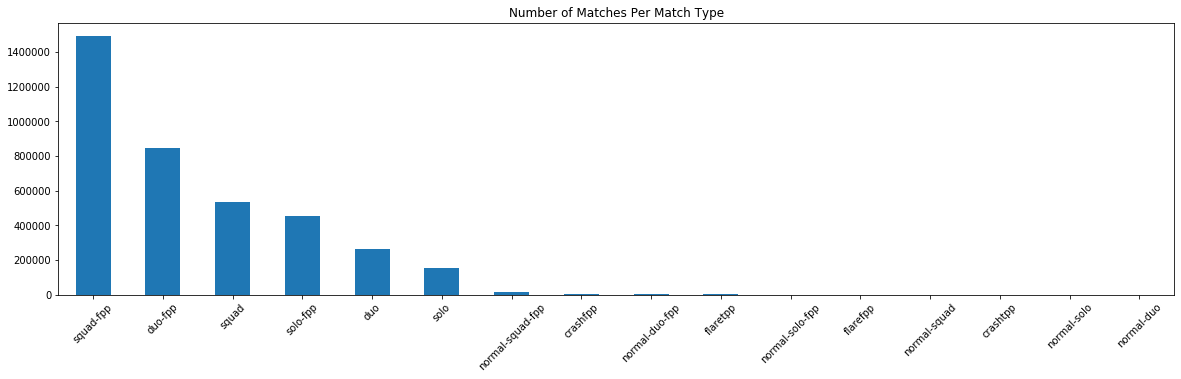

In [8]:
#The following shows the number of matches per type. Later I will attempt to run reg. equations for each match type.
match_type = master_data['matchType']
counts = match_type.value_counts()
counts.plot(kind = 'bar')
plt.title('Number of Matches Per Match Type')
plt.xticks(rotation=45)
plt.show()

### Inferential Statistics

<function matplotlib.pyplot.show(*args, **kw)>

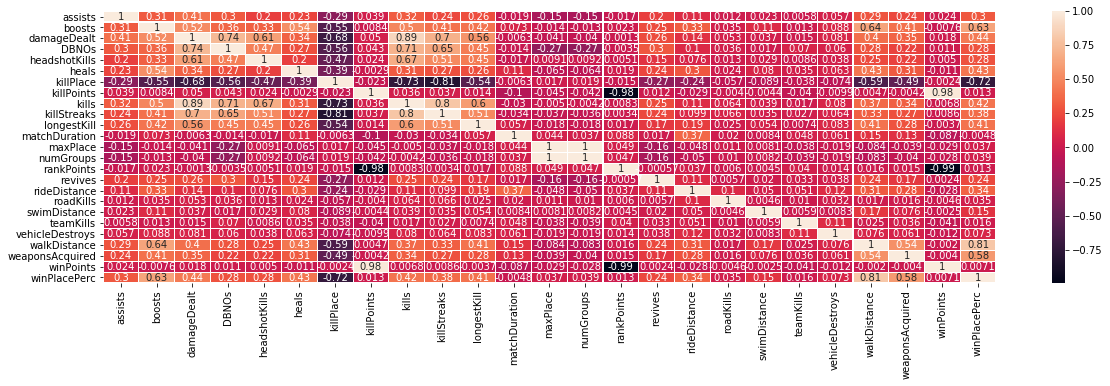

In [9]:
#The heatmap below shows two things: first, the correlations between each variable as it relates to win place percentage;
#second, and more importantly, some of our variables have a perfect correllation .
corr_data = numeric_data.corr()
sb.heatmap(corr_data, annot=True,linewidths=.1, xticklabels=corr_data.columns.values, yticklabels=corr_data.columns.values)
plt.show

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<function matplotlib.pyplot.show(*args, **kw)>

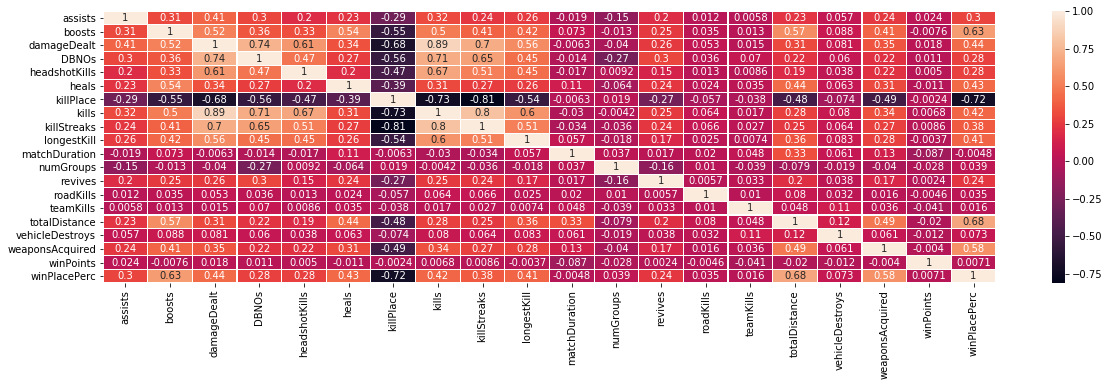

In [10]:
#Since rankPoints and killPoints correlate highly with winPoints, I'm going to drop these from my dataset.
#As well, I'll combine all distances into one variable called 'moveDistance'. 
#Max place correllates too well w/number of groups; I'll drop that. 
trim = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'kills', 'killStreaks', 'longestKill', 'matchDuration', 
             'numGroups', 'revives', 'rideDistance','roadKills', 'swimDistance', 'teamKills', 
             'vehicleDestroys', 'walkDistance', 'weaponsAcquired','winPoints', 'winPlacePerc']
trim_data = numeric_data[trim]
totalDistance = trim_data['swimDistance'] + trim_data['rideDistance'] + trim_data['walkDistance']
trim_data['totalDistance'] = totalDistance
trim_data = trim_data.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis = 1)
final_trim = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'kills', 'killStreaks', 'longestKill', 'matchDuration', 
             'numGroups', 'revives','roadKills', 'teamKills', 'totalDistance', 
             'vehicleDestroys', 'weaponsAcquired','winPoints', 'winPlacePerc']
final_data = trim_data[final_trim]
corr_final = final_data.corr()
sb.heatmap(corr_final, annot=True,linewidths=.1, xticklabels=corr_final.columns.values, 
           yticklabels=corr_final.columns.values)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

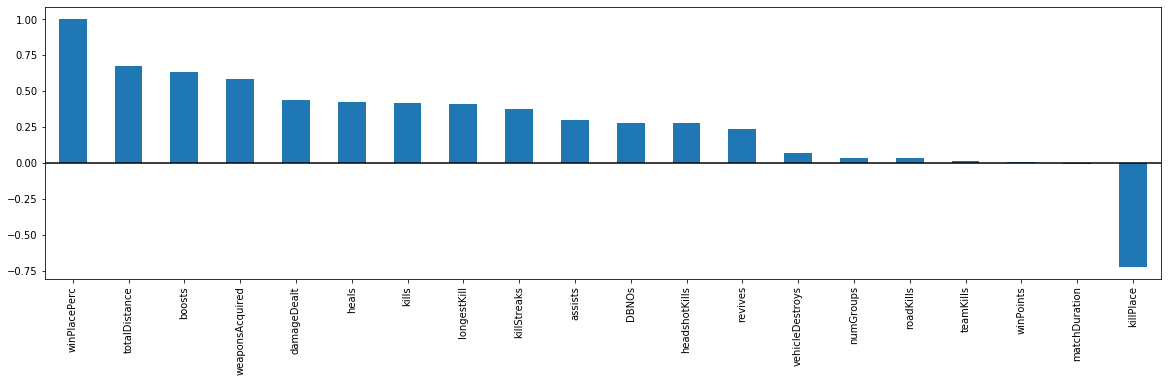

In [11]:
corr_bar = corr_final.sort_values('winPlacePerc', ascending = False)
corr_bar['winPlacePerc'].plot(kind='bar')
plt.axhline(0, color = 'black')
plt.show

In [12]:
#The following contains code for my regression equation for all match types. 
final_data = final_data[~np.isnan(final_data.winPlacePerc)]
regression_data = final_data.drop(['winPlacePerc'], axis = 1)
xmodel = regression_data
xmodel = add_constant(xmodel)
ymodel = final_data['winPlacePerc']
olsmodel = sts.OLS(ymodel, xmodel)
model_results = olsmodel.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winPlacePerc   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 7.259e+05
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:13   Log-Likelihood:             1.9995e+06
No. Observations:             3779919   AIC:                        -3.999e+06
Df Residuals:                 3779899   BIC:                        -3.999e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0341      0.001   1626.737      0.000       1.033       1.035
assists             0.0208      0.000    147.474      0.000       0.021       0.021
boosts              0.0285   6.31e-05    451.299      0.000       0.028       0.029
damageDealt      4.981e-05   1.06e-06     47.056      0.000    4.77e-05    5.19e-05
DBNOs              -0.0046      0.000    -42.819      0.000      -0.005      -0.004
headshotKills       0.0022      0.000     12.974      0.000       0.002       0.002
heals               0.0005   3.34e-05     14.180      0.000       0.000       0.001
killPlace          -0.0083   5.78e-06  -1432.197      0.000      -0.008      -0.008
kills              -0.0184      0.000   -138.054      0.000      -0.019      -0.018
killStreaks        -0.1584      0.000   -703.953      0.000      -0.159      -0.158
longestKill         0.0002   1.88e-06     83.955      0.000       0.000       0.000
matchDuration      -0.0002   3.11e-07   -608.332      0.000      -0.000      -0.000
numGroups           0.0011   3.47e-06    323.407      0.000       0.001       0.001
revives             0.0190      0.000    112.843      0.000       0.019       0.019
roadKills          -0.0419      0.001    -41.517      0.000      -0.044      -0.040
teamKills          -0.0206      0.000    -46.367      0.000      -0.021      -0.020
totalDistance    4.356e-05      5e-08    870.962      0.000    4.35e-05    4.37e-05
vehicleDestroys    -0.0146      0.001    -18.172      0.000      -0.016      -0.013
weaponsAcquired     0.0166   3.72e-05    446.629      0.000       0.017       0.017
winPoints        1.562e-06   9.97e-08     15.672      0.000    1.37e-06    1.76e-06
==============================================================================
Omnibus:                   311229.383   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1587644.135
Skew:                          -0.233   Prob(JB):                         0.00
Kurtosis:                       6.140   Cond. No.                     4.23e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Statistics per Match Type

Box plot for crashfpp matches


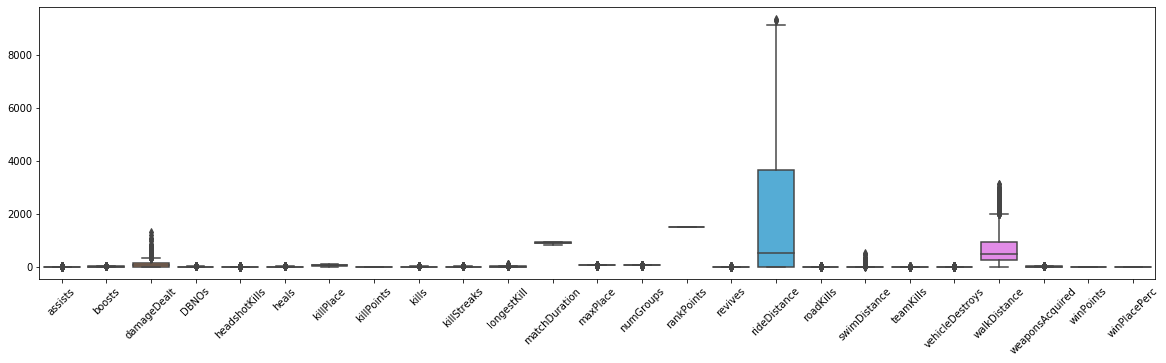

Heat map for crashfpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


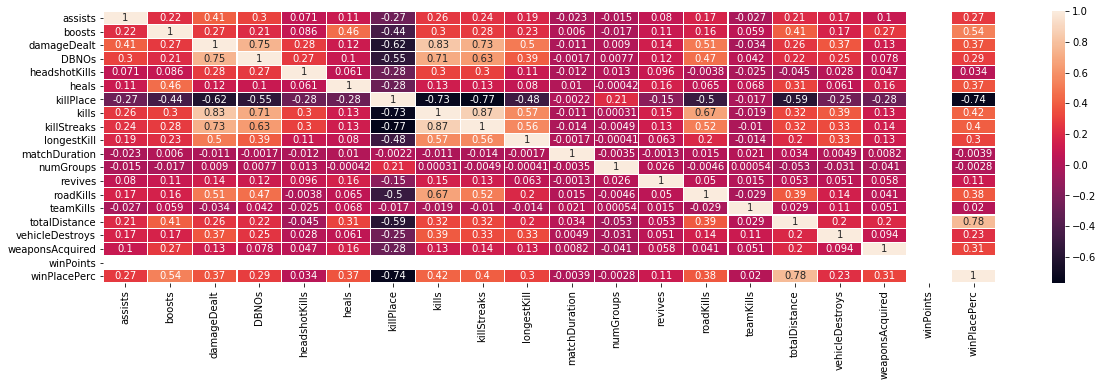

Regression for crashfpp matches
5364
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1254.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:15   Log-Likelihood:                 3163.6
No. Observations:                5364   AIC:                            -6289.
Df Residuals:                    5345   BIC:                            -6164.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value enco

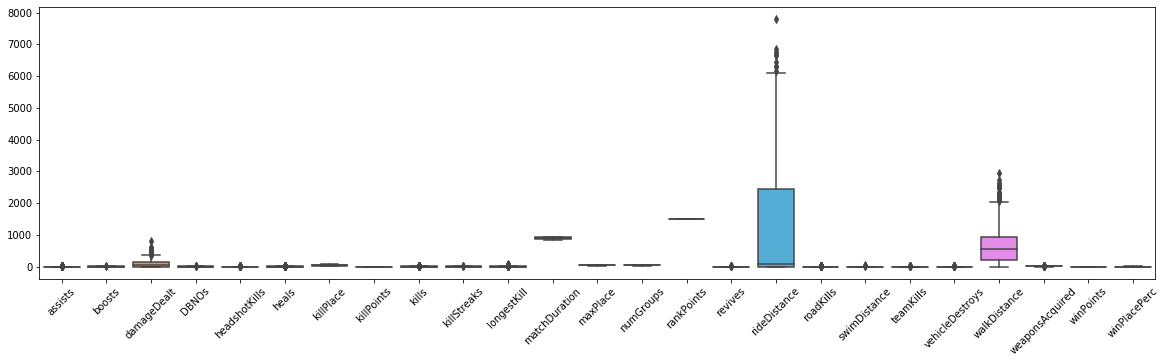

Heat map for crashtpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


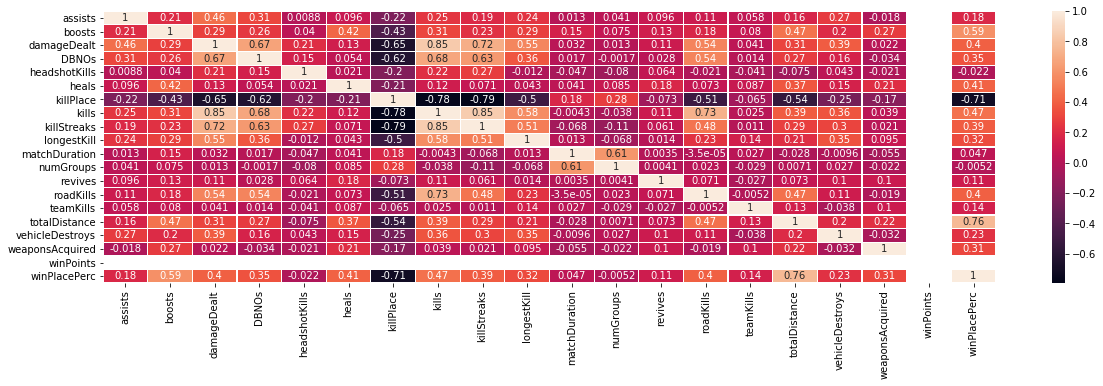

Regression for crashtpp matches
318
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     70.75
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           2.45e-96
Time:                        20:41:16   Log-Likelihood:                 190.60
No. Observations:                 318   AIC:                            -343.2
Df Residuals:                     299   BIC:                            -271.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const 

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value enco

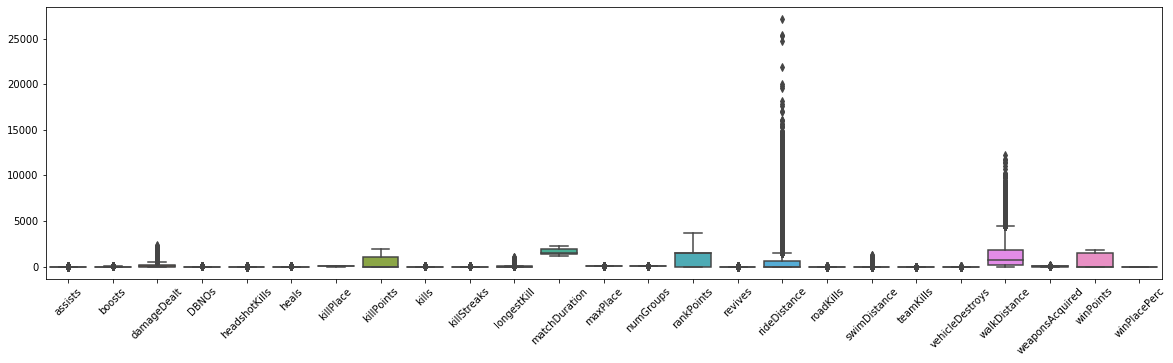

Heat map for duo matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


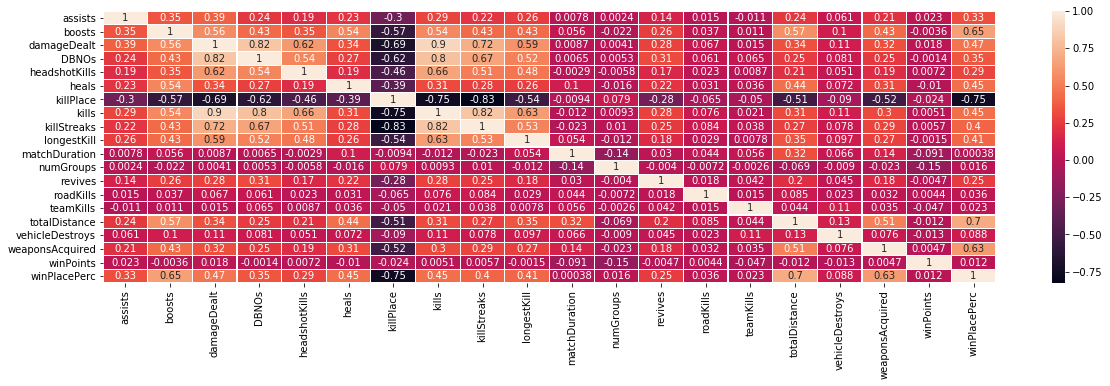

Regression for duo matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


266157
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 6.897e+04
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:21   Log-Likelihood:             1.7675e+05
No. Observations:              266157   AIC:                        -3.535e+05
Df Residuals:                  266137   BIC:                        -3.532e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6533      0.0

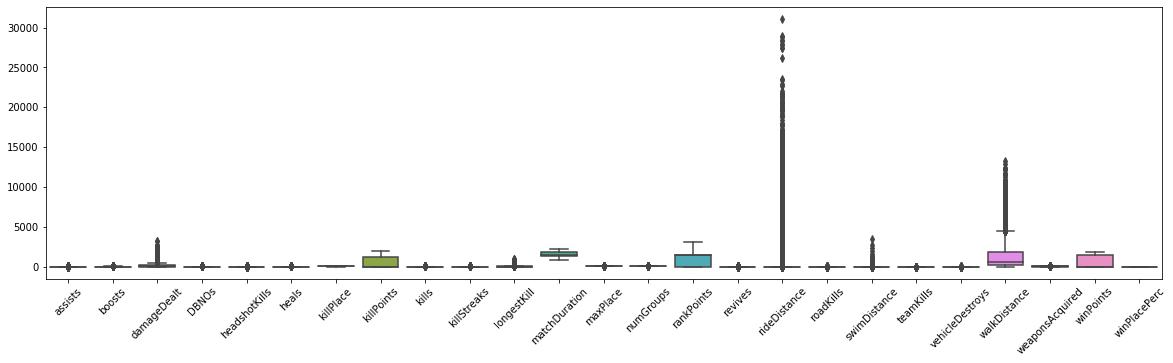

Heat map for duo-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


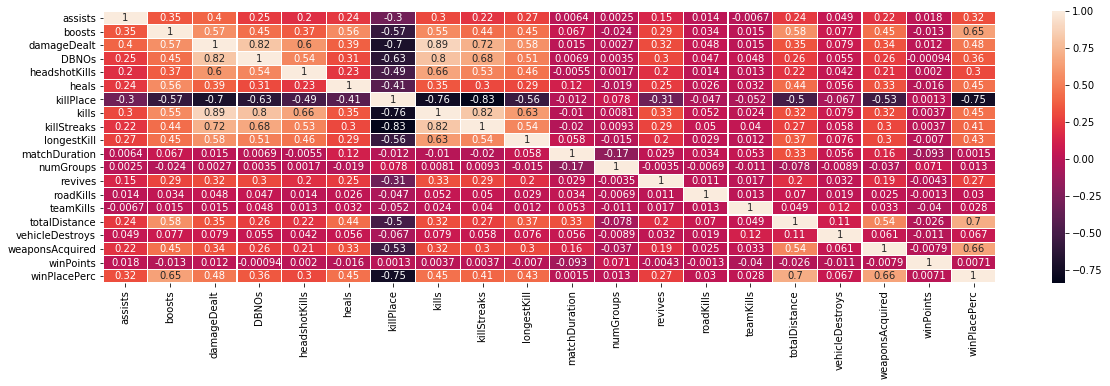

Regression for duo-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


847179
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 2.401e+05
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:30   Log-Likelihood:             6.0177e+05
No. Observations:              847179   AIC:                        -1.203e+06
Df Residuals:                  847159   BIC:                        -1.203e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6442      0.0

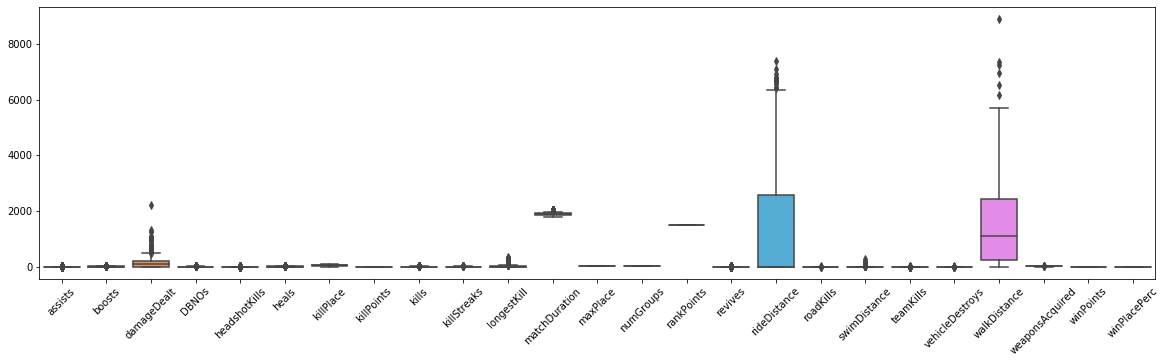

Heat map for flarefpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


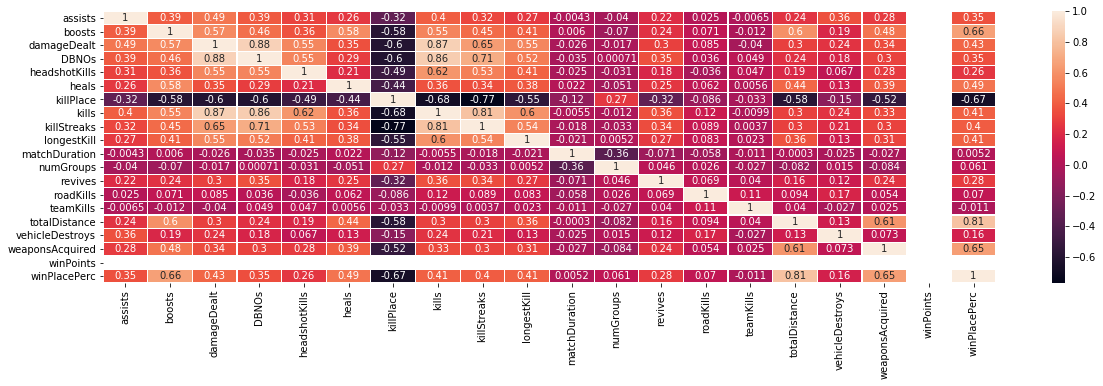

Regression for flarefpp matches
617
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     147.4
Date:                Fri, 17 Apr 2020   Prob (F-statistic):          4.51e-206
Time:                        20:41:32   Log-Likelihood:                 349.02
No. Observations:                 617   AIC:                            -660.0
Df Residuals:                     598   BIC:                            -576.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const 

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value enco

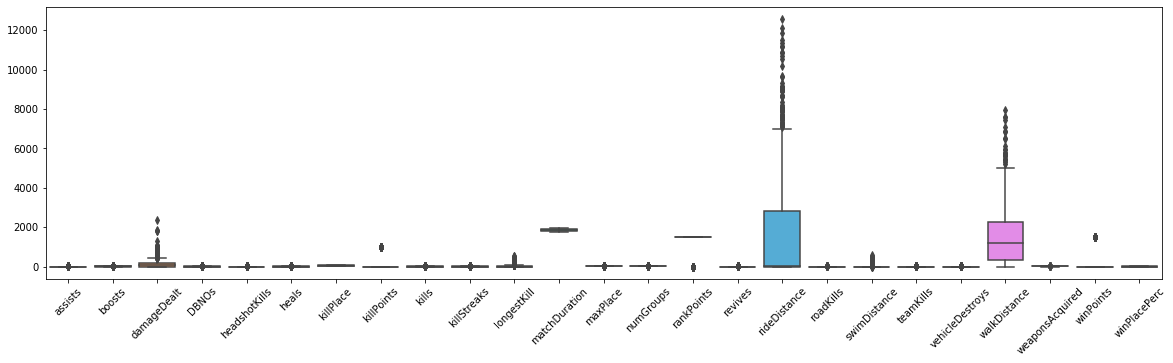

Heat map for flaretpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


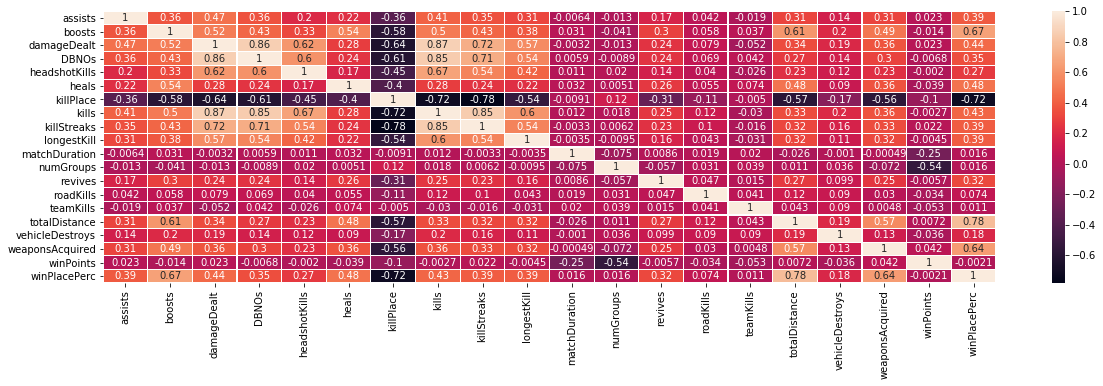

Regression for flaretpp matches
2130
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     420.1
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:34   Log-Likelihood:                 1101.1
No. Observations:                2130   AIC:                            -2162.
Df Residuals:                    2110   BIC:                            -2049.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


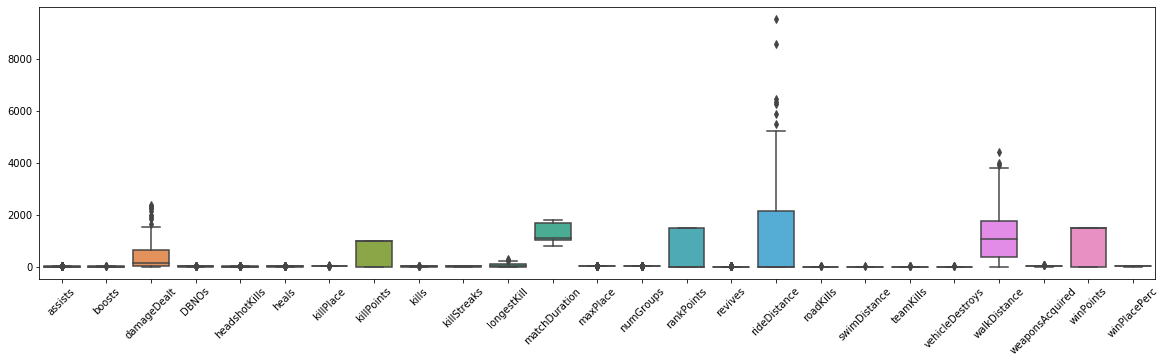

Heat map for normal-duo matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


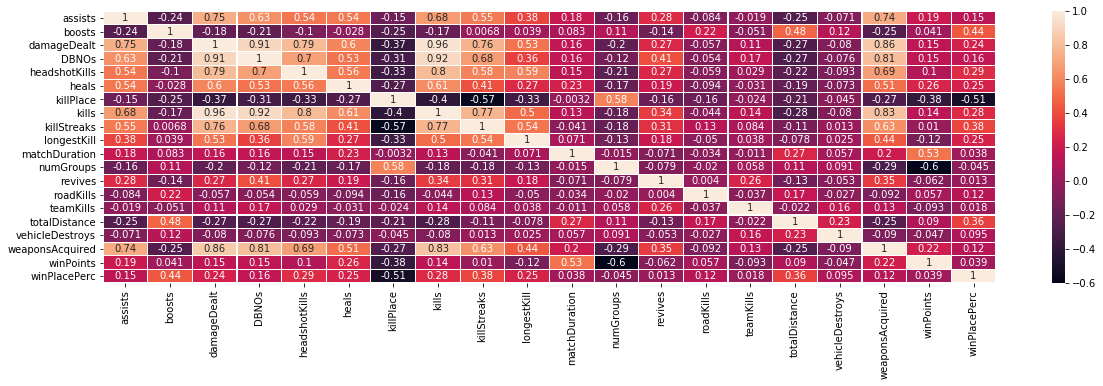

Regression for normal-duo matches
168
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     8.740
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           3.58e-16
Time:                        20:41:36   Log-Likelihood:                 14.997
No. Observations:                 168   AIC:                             10.01
Df Residuals:                     148   BIC:                             72.48
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
cons

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


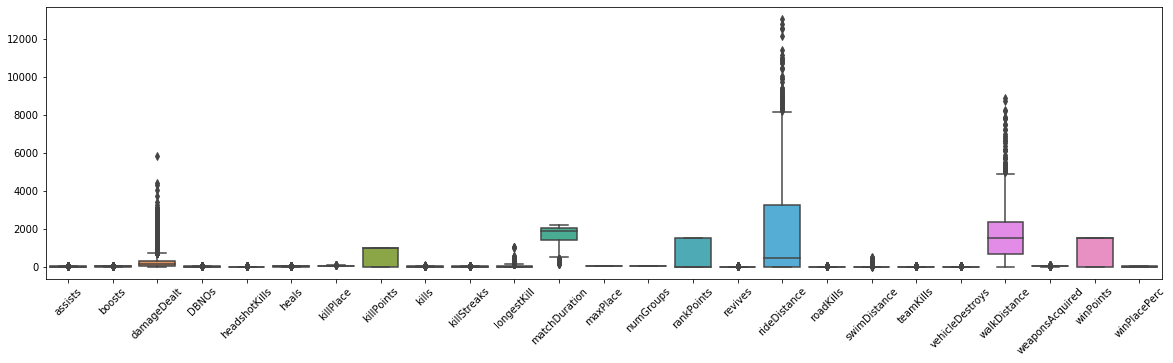

Heat map for normal-duo-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


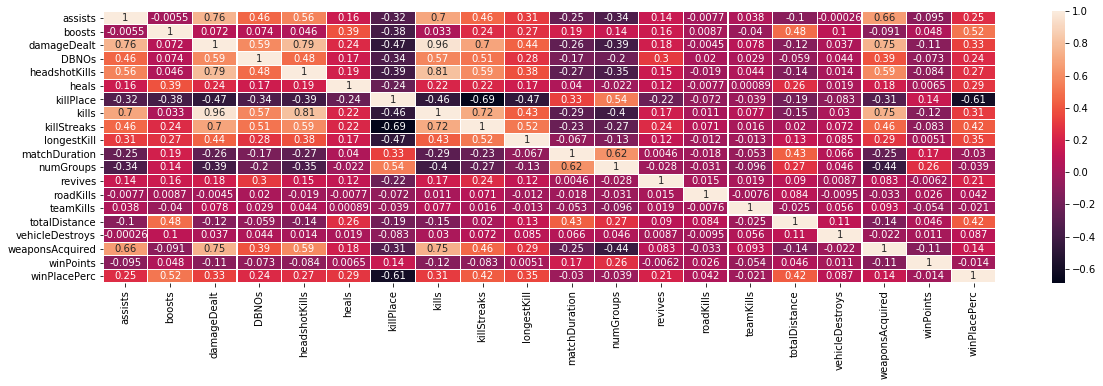

Regression for normal-duo-fpp matches
4696
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     353.5
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:38   Log-Likelihood:                 940.98
No. Observations:                4696   AIC:                            -1842.
Df Residuals:                    4676   BIC:                            -1713.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


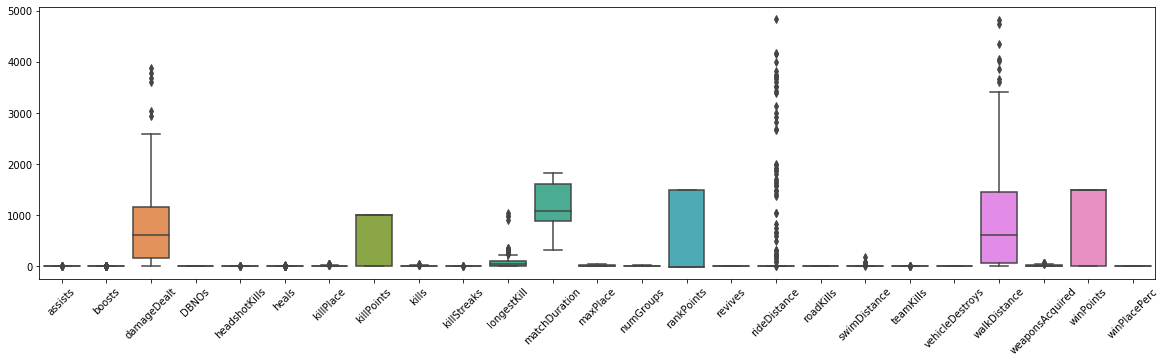

Heat map for normal-solo matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


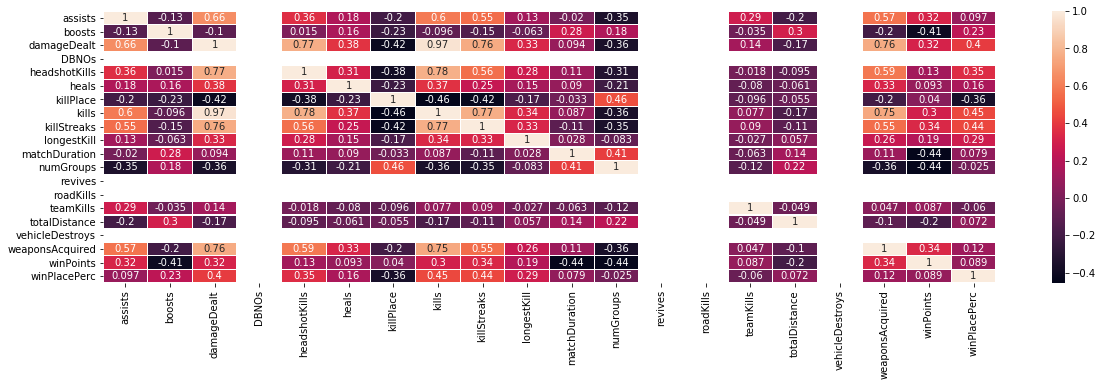

Regression for normal-solo matches
279
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     14.13
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           3.69e-26
Time:                        20:41:39   Log-Likelihood:                0.71443
No. Observations:                 279   AIC:                             30.57
Df Residuals:                     263   BIC:                             88.67
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
con

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  con

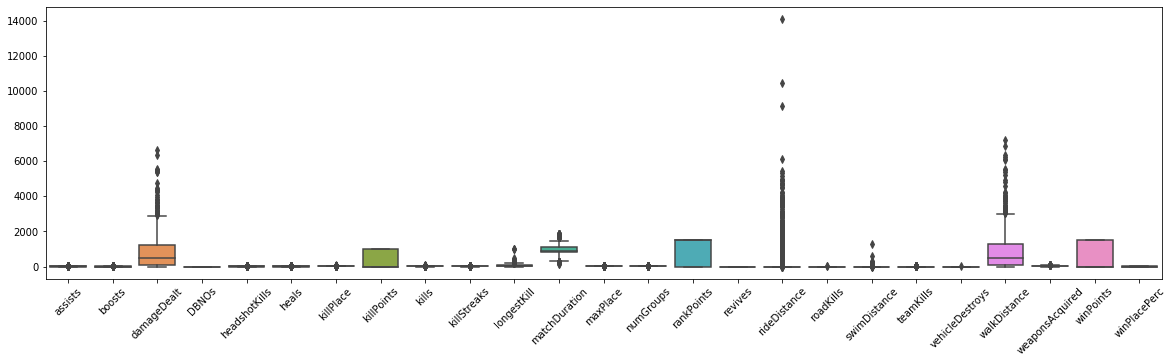

Heat map for normal-solo-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


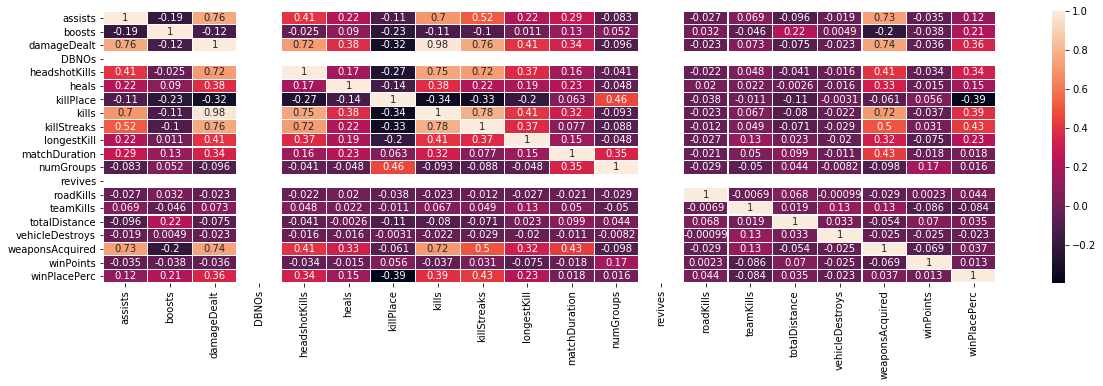

Regression for normal-solo-fpp matches
1436
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     53.97
Date:                Fri, 17 Apr 2020   Prob (F-statistic):          3.70e-140
Time:                        20:41:41   Log-Likelihood:                0.62958
No. Observations:                1436   AIC:                             34.74
Df Residuals:                    1418   BIC:                             129.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


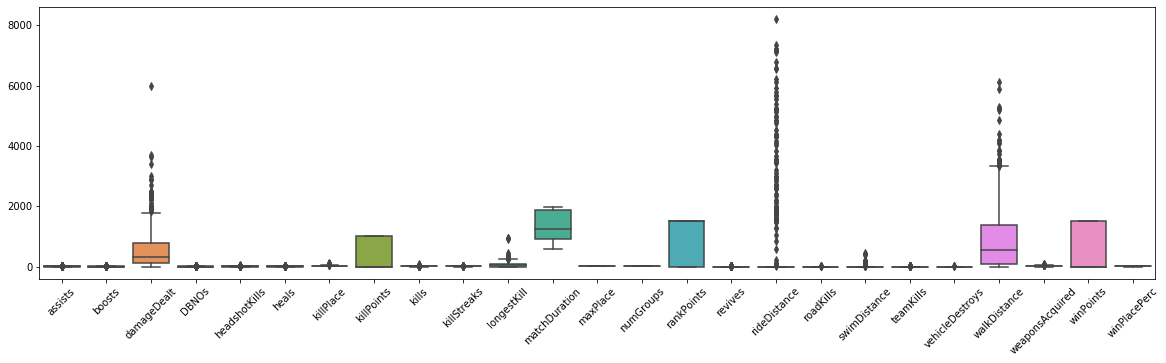

Heat map for normal-squad matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


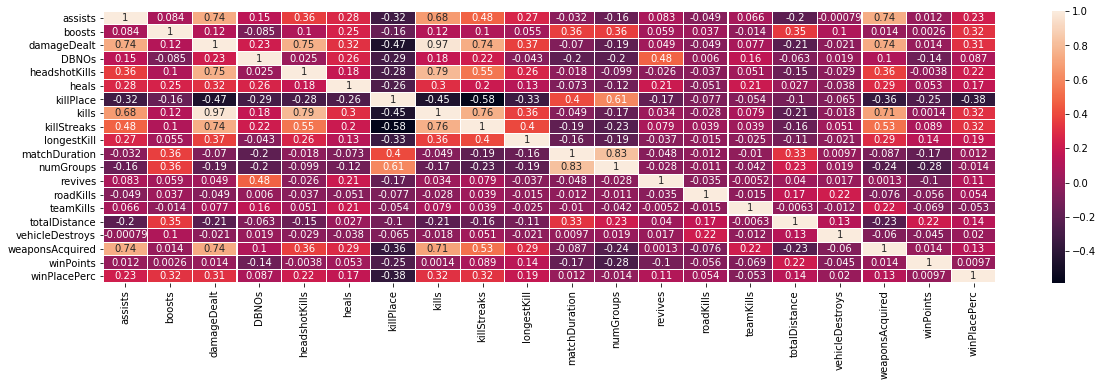

Regression for normal-squad matches
448
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     9.055
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           6.98e-22
Time:                        20:41:43   Log-Likelihood:                -68.319
No. Observations:                 448   AIC:                             176.6
Df Residuals:                     428   BIC:                             258.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
co

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


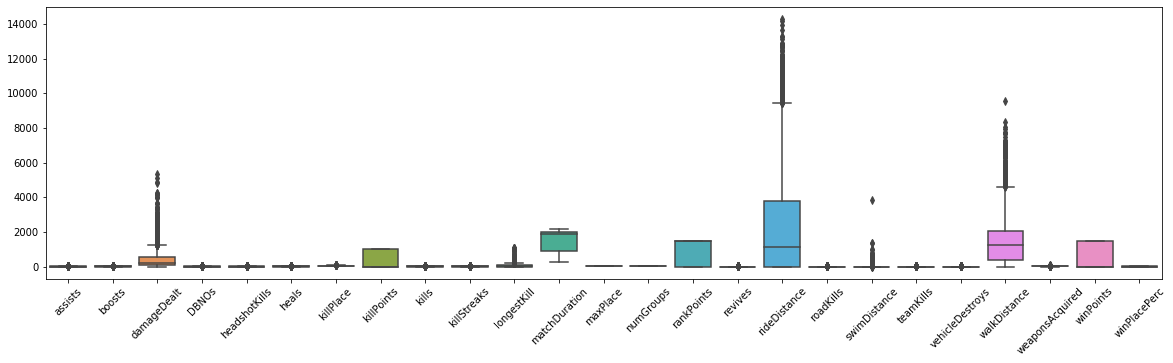

Heat map for normal-squad-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


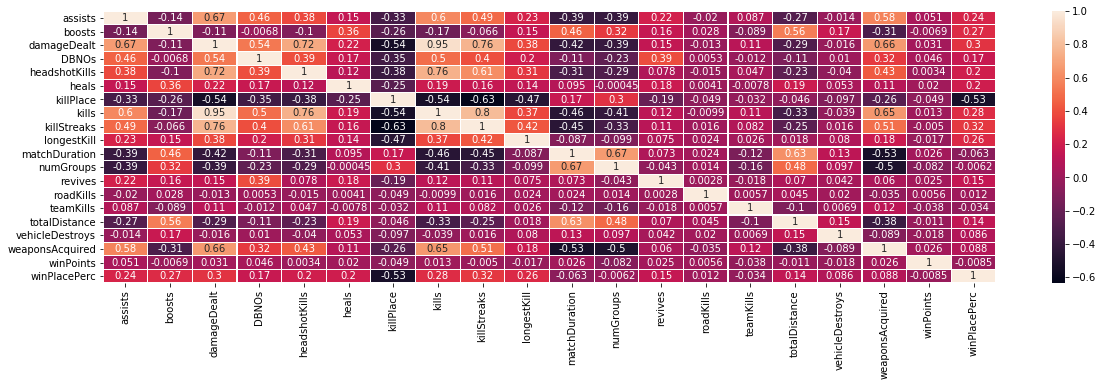

Regression for normal-squad-fpp matches
14553
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     432.6
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:45   Log-Likelihood:                -1093.7
No. Observations:               14553   AIC:                             2227.
Df Residuals:                   14533   BIC:                             2379.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


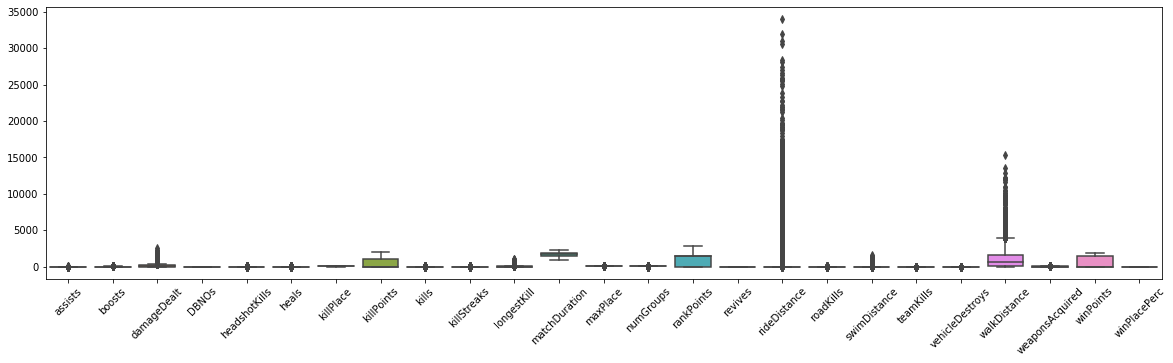

Heat map for solo matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


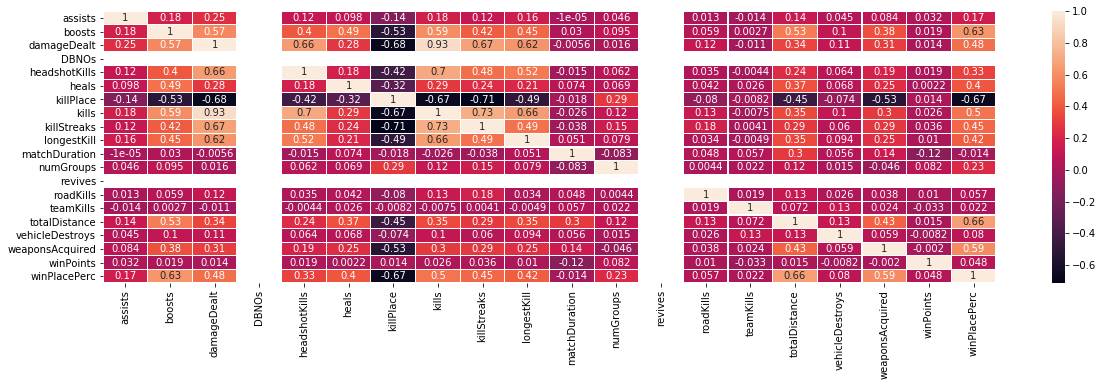

Regression for solo matches
154792


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 4.296e+04
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:48   Log-Likelihood:                 97717.
No. Observations:              154792   AIC:                        -1.954e+05
Df Residuals:                  154774   BIC:                        -1.952e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3525      0.003    1

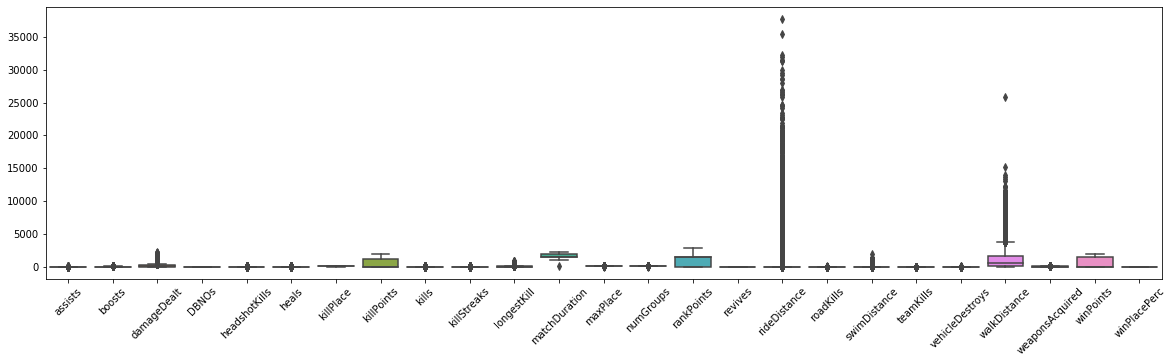

Heat map for solo-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


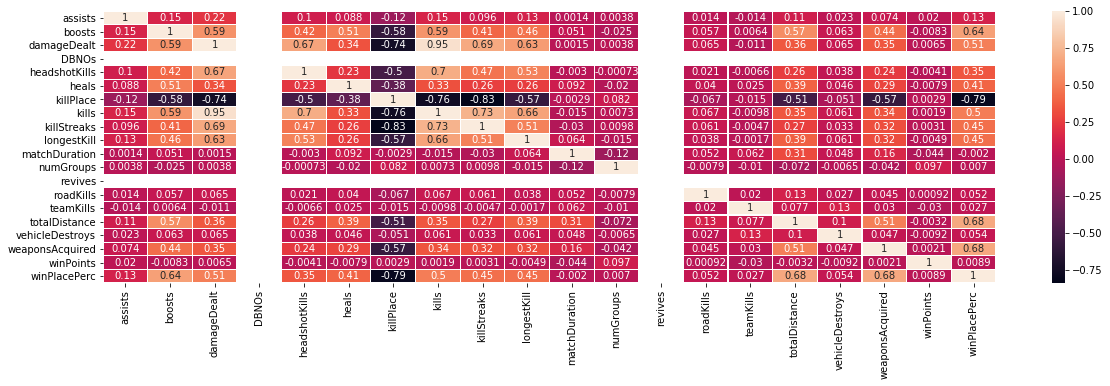

Regression for solo-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


456203
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 1.919e+05
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:53   Log-Likelihood:             3.8812e+05
No. Observations:              456203   AIC:                        -7.762e+05
Df Residuals:                  456185   BIC:                        -7.760e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6414      0.0

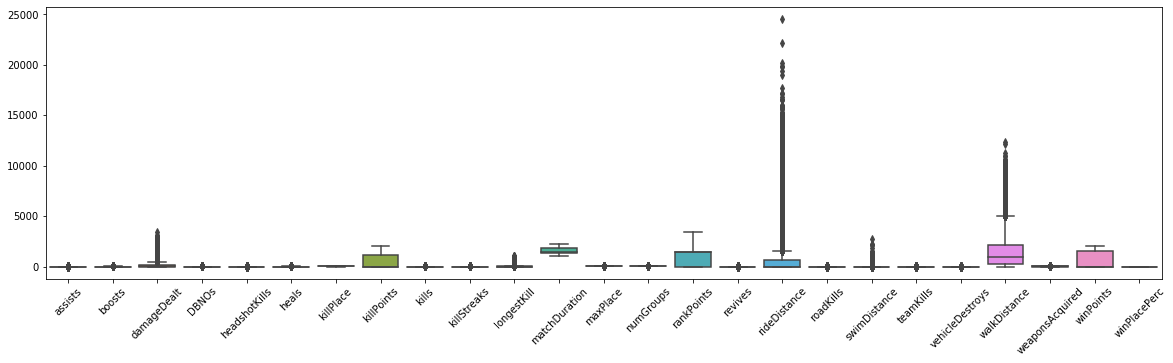

Heat map for squad matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


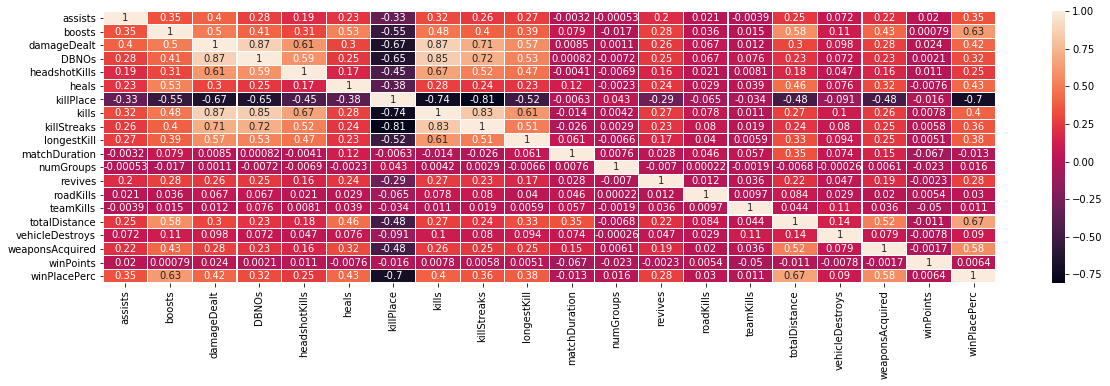

Regression for squad matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


532556
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 9.344e+04
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:42:00   Log-Likelihood:             2.4848e+05
No. Observations:              532556   AIC:                        -4.969e+05
Df Residuals:                  532536   BIC:                        -4.967e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8727      0.0

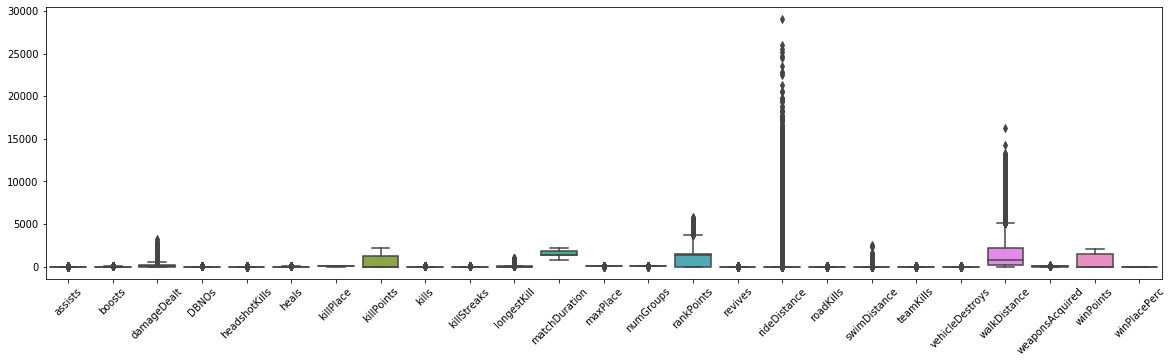

Heat map for squad-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


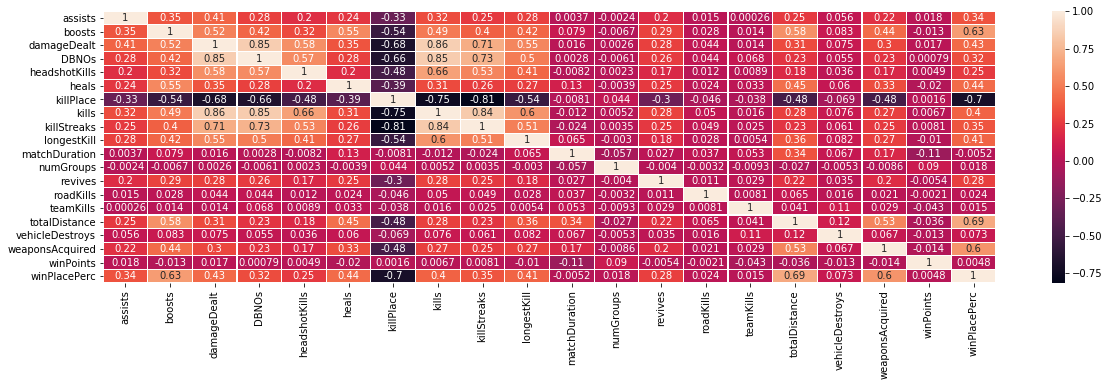

Regression for squad-fpp matches


C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1493023
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 2.875e+05
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:42:14   Log-Likelihood:             7.7118e+05
No. Observations:             1493023   AIC:                        -1.542e+06
Df Residuals:                 1493003   BIC:                        -1.542e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8635      0.

In [13]:
#After seeing the results for all matches together, I thought it'd be best to see the boxplots, heat maps, and reg. 
#outputs for each match type. The following contains code for each of those. 

match_array = ['crashfpp', 'crashtpp', 'duo', 'duo-fpp', 'flarefpp', 'flaretpp', 'normal-duo', 'normal-duo-fpp', 'normal-solo',
               'normal-solo-fpp', 'normal-squad', 'normal-squad-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp']

def box_type(box_type='') :
    if box_type!='':
        print("Box plot for " + box_type + " matches")
        match_type = master_data[master_data.matchType == box_type]
    else:
        print("Box plot for all matches")
        match_type = master_data
    numeric_type = match_type[numeric]
    mpl.rcParams['figure.figsize'] = (20,5)
    sb.boxplot(data=numeric_type)
    plt.xticks(rotation=45)
    plt.show()

def match_corr(match_corr='') :
    if match_corr!='':
        print("Heat map for " + match_corr + " matches")
        match_type = master_data[master_data.matchType == match_corr]
    else:
        print("Regression for all matches")
        match_type  = master_data
    match_type = match_type[~np.isnan(match_type.winPlacePerc)]   
    trim_type = match_type[trim]
    totalDistance = trim_type['swimDistance'] + trim_type['rideDistance'] + trim_type['walkDistance']
    trim_type['totalDistance'] = totalDistance
    trim_type = trim_type.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis = 1)
    final_trim = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'kills', 'killStreaks', 'longestKill', 'matchDuration', 
             'numGroups', 'revives','roadKills', 'teamKills', 'totalDistance', 
             'vehicleDestroys', 'weaponsAcquired','winPoints', 'winPlacePerc']
    final_type = trim_type[final_trim] 
    corr_type = final_type.corr()
    sb.heatmap(corr_type, annot=True,linewidths=.1, xticklabels=corr_type.columns.values, 
           yticklabels=corr_type.columns.values)
    plt.show()
    
def match_var(match_var='') :
    if match_var!='':
        print("Regression for " + match_var + " matches")
        match_type = master_data[master_data.matchType == match_var]
    else:
        print("Regression for all matches")
        match_type = master_data
    match_type = match_type[~np.isnan(match_type.winPlacePerc)]   
    trim_type = match_type[trim]
    totalDistance = trim_type['swimDistance'] + trim_type['rideDistance'] + trim_type['walkDistance']
    trim_type['totalDistance'] = totalDistance
    trim_type = trim_type.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis = 1)
    final_trim = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'kills', 'killStreaks', 'longestKill', 'matchDuration', 
             'numGroups', 'revives','roadKills', 'teamKills', 'totalDistance', 
             'vehicleDestroys', 'weaponsAcquired','winPoints', 'winPlacePerc']
    final_type = trim_type[final_trim]    
    regression_type = final_type.drop(['winPlacePerc'], axis = 1)
    x = regression_type
    y = final_type['winPlacePerc']
    x = add_constant(x)
    print(len(x))
    reg_type = sts.OLS(y, x)
    reg_type_results = reg_type.fit()
    print(reg_type_results.summary())


for i in match_array :
    box_type(i)
    match_corr(i)
    match_var(i)
    
 

### Model vs. Out-of-Sample Data

In [14]:
test_trim = test_data[trim]
testtotalDistance = test_trim['swimDistance'] + test_trim['rideDistance'] + test_trim['walkDistance']
test_trim['totalDistance'] = testtotalDistance
test_trim = test_trim.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis = 1)
final_test_trim = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'kills', 'killStreaks', 'longestKill', 'matchDuration', 
             'numGroups', 'revives','roadKills', 'teamKills', 'totalDistance', 
             'vehicleDestroys', 'weaponsAcquired','winPoints', 'winPlacePerc']
final_test = test_trim[final_test_trim]
final_test = final_test[~np.isnan(final_test.winPlacePerc)]
regression_test = final_test.drop(['winPlacePerc'], axis = 1)
xtest = regression_test
xtest = add_constant(xtest)
ytest = final_test['winPlacePerc']
olstest = sts.OLS(ytest, xtest)
test_results = olstest.fit()
test_results.summary()

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winPlacePerc   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 1.284e+05
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:42:16   Log-Likelihood:             3.5329e+05
No. Observations:              667044   AIC:                        -7.065e+05
Df Residuals:                  667024   BIC:                        -7.063e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0346      0.002    683.086      0.000       1.032       1.038
assists             0.0208      0.000     61.990      0.000       0.020       0.021
boosts              0.0285      0.000    189.689      0.000       0.028       0.029
damageDealt      4.769e-05   2.52e-06     18.928      0.000    4.27e-05    5.26e-05
DBNOs              -0.0043      0.000    -16.803      0.000      -0.005      -0.004
headshotKills       0.0011      0.000      2.881      0.004       0.000       0.002
heals               0.0004   7.95e-05      4.580      0.000       0.000       0.001
killPlace          -0.0083   1.38e-05   -602.527      0.000      -0.008      -0.008
kills              -0.0185      0.000    -58.108      0.000      -0.019      -0.018
killStreaks        -0.1588      0.001   -295.350      0.000      -0.160      -0.158
longestKill         0.0002   4.49e-06     37.338      0.000       0.000       0.000
matchDuration      -0.0002   7.38e-07   -255.084      0.000      -0.000      -0.000
numGroups           0.0011   8.26e-06    135.538      0.000       0.001       0.001
revives             0.0187      0.000     47.028      0.000       0.018       0.019
roadKills          -0.0465      0.002    -19.525      0.000      -0.051      -0.042
teamKills          -0.0196      0.001    -18.584      0.000      -0.022      -0.018
totalDistance    4.322e-05   1.19e-07    363.808      0.000     4.3e-05    4.35e-05
vehicleDestroys    -0.0122      0.002     -6.307      0.000      -0.016      -0.008
weaponsAcquired     0.0169   8.95e-05    188.615      0.000       0.017       0.017
winPoints        1.471e-06   2.37e-07      6.200      0.000    1.01e-06    1.94e-06
==============================================================================
Omnibus:                    53125.670   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267915.168
Skew:                          -0.216   Prob(JB):                         0.00
Kurtosis:                       6.075   Cond. No.                     4.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
def match_test(match_test='') :
    if match_test!='':
        print("Regression for "+ match_test + " matches")
        match_type = test_data[test_data.matchType == match_test]
    else:
        print("Regression for all matches")
        match_type = test_data
    match_type = match_type[~np.isnan(match_type.winPlacePerc)]   
    trim_type = match_type[trim]
    totalDistance = trim_type['swimDistance'] + trim_type['rideDistance'] + trim_type['walkDistance']
    trim_type['totalDistance'] = totalDistance
    trim_type = trim_type.drop(['swimDistance', 'rideDistance', 'walkDistance'], axis = 1)
    final_trim = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
             'kills', 'killStreaks', 'longestKill', 'matchDuration', 
             'numGroups', 'revives','roadKills', 'teamKills', 'totalDistance', 
             'vehicleDestroys', 'weaponsAcquired','winPoints', 'winPlacePerc']
    final_type = trim_type[final_trim]    
    regression_type = final_type.drop(['winPlacePerc'], axis = 1)
    x = regression_type
    y = final_type['winPlacePerc']
    x = add_constant(x)
    print(len(x))
    reg_type = sts.OLS(y, x)
    reg_type_results = reg_type.fit()
    print(reg_type_results.summary())
    
for i in match_array :
    match_test(i)

Regression for crashfpp matches
923
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     218.5
Date:                Fri, 17 Apr 2020   Prob (F-statistic):          4.93e-314
Time:                        20:42:16   Log-Likelihood:                 546.30
No. Observations:                 923   AIC:                            -1055.
Df Residuals:                     904   BIC:                            -962.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const 

C:\Users\Connor\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Connor\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Connor\anaconda3\lib\site-packages\scipy\stats\_distn

                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 1.215e+04
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:42:16   Log-Likelihood:                 31256.
No. Observations:               47434   AIC:                        -6.247e+04
Df Residuals:                   47414   BIC:                        -6.230e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6187      0.011     

47
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     5.226
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           5.08e-05
Time:                        20:42:17   Log-Likelihood:                 22.811
No. Observations:                  47   AIC:                            -13.62
Df Residuals:                      31   BIC:                             15.98
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5763      0.188  

27151
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     8055.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:42:17   Log-Likelihood:                 17890.
No. Observations:               27151   AIC:                        -3.574e+04
Df Residuals:                   27133   BIC:                        -3.560e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3608      0.00

263162
                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                 5.095e+04
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:42:18   Log-Likelihood:             1.3644e+05
No. Observations:              263162   AIC:                        -2.728e+05
Df Residuals:                  263142   BIC:                        -2.726e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8630      0.0

### Exporting Results Below

In [16]:
corr_bar.to_csv('corr_bar.csv')
corr_final.to_csv('corr_final.csv')

In [17]:
#Adding in match type back into both sets of data
categorical_sample = master_data['matchType']
categorical_test = test_data['matchType']
final_data['matchType'] = categorical_sample
final_test['matchType'] = categorical_test

In [18]:
final_data.to_csv('final_data.csv')
final_test.to_csv('final_test.csv')